# Classification of drug consumption

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [279]:
from IPython.core.display import SVG
from IPython.display import Image

In [2]:
import matplotlib.pyplot as plt

In [3]:
from numpy import loadtxt

In [4]:
import pandas as pd

In [5]:
import pydotplus

In [136]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals.six import StringIO  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.utils.validation import column_or_1d

In [210]:
from dtreeviz.trees import *

In [7]:
import xgboost as xgb
from xgboost import XGBClassifier

## Setup

In [246]:
MAX_TREE_DEPTH=5

In [8]:
df = pd.read_excel('drug_consumption.xls')

In [9]:
demographic_features = [
    'Ethnicity',
    'Country',
    'Education',
    'Age',
    'Gender',
]

personality_traits = [
    'Nscore',
    'Escore',
    'Oscore',
    'Ascore',
    'Cscore',
    'Impulsive',
    'SS'
]

targets = [
    'Alcohol',
    'Amphet',
    'Amyl',
    'Benzos',
    'Caff',
    'Cannabis',
    'Choc',
    'Coke',
    'Crack',
    'Ecstasy',
    'Heroin',
    'Ketamine',
    'Legalh',
    'LSD',
    'Meth',
    'Shrooms',
    'Nicotine',
    'Semer',
    'VSA'
]

## Utilities

In [360]:
classifiers = [
    XGBClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier(n_estimators=10,max_depth=None,min_samples_split=2,random_state=0),
    DecisionTreeClassifier(max_depth=MAX_TREE_DEPTH,min_samples_split=2,random_state=0)
]

In [326]:
def prediction_accuracy(clf, X_train, X_test, y_train, y_test):
    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print(f'{clf.__class__.__name__}\n\tAccuracy: {accuracy * 100.0}')

In [380]:
def plot_via_dtreeviz(config):
    viz = dtreeviz(config['clf'],
             config['X'],
             config['label_encoded_y'],
             target_name = config['target_name'],
             feature_names = config['feature_names'],
             class_names= config['class_names'])
    viz.save(f'img/{config["target_name"][0]}.svg')
    return viz

In [381]:
def plot_xgb_trees(features, labels):
    print('plot_xgb_trees')
    X, y = features, labels
    # Create the DMatrix: housing_dmatrix
    dmatrix = xgb.DMatrix(data=X, label=y)

    # Create the parameter dictionary: params
    params = {
        'objective':'reg:squarederror',
        'max_depth':MAX_TREE_DEPTH
    }

    # Train the model: xg_reg
    xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

    xgb.plot_tree(xg_reg, num_trees=0)
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.show()

    xgb.plot_importance(xg_reg)
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.show()

In [382]:
def setup_classifier(data_frame, features, target):
    def classify(clf):
        # split data into X and y
        X = data_frame[features]
        y = data_frame[target]
        y = column_or_1d(y, warn=False)

        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y)
        label_encoded_y = label_encoder.transform(y)
    
        seed = 7
        test_size = 0.33
        X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)
        # fit model no training data
        clf.fit(X_train, y_train)
        viz_data = None
        
        if clf.__class__.__name__ == 'XGBClassifier':
            plot_xgb_trees(X, label_encoded_y)
        elif clf.__class__.__name__ == 'DecisionTreeClassifier':
            viz_data = {'clf': clf,
                        'X': X,
                        'label_encoded_y': label_encoded_y,
                        'target_name':target,
                        'feature_names': features,
                        'class_names': [
                            'Never Used',
                            'Used over a Decade Ago',
                            'Used in Last Decade',
                            'Used in Last Year',
                            'Used in Last Month',
                            'Used in Last Week', 'Used in Last Day'
                        ]}
        return clf, X_train, X_test, y_train, y_test, viz_data
    return classify

In [383]:
def print_accuracy(clfs, target_name, plot_it=True):
    print(f'Predicting accuracy for "{target_name}":\n')
    viz = None
    for clf in clfs:
        model, X_train, X_test, y_train, y_test, viz_data = setup_classifier(df, demographic_features + personality_traits, [target_name])(clf)
        if clf.__class__.__name__ == 'DecisionTreeClassifier':
            viz = plot_via_dtreeviz(viz_data)
        prediction_accuracy(model, X_train, X_test, y_train, y_test)
    if plot_it:
        return viz
    return None

## Target: _Alcohol_

Predicting accuracy for "Alcohol":

plot_xgb_trees


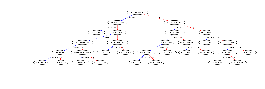

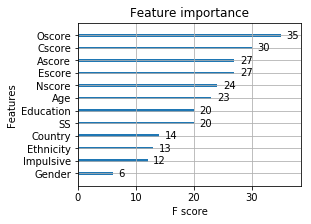

XGBClassifier
	Accuracy: 37.56019261637239
AdaBoostClassifier
	Accuracy: 26.64526484751204
RandomForestClassifier
	Accuracy: 36.91813804173354
DecisionTreeClassifier
	Accuracy: 36.43659711075441


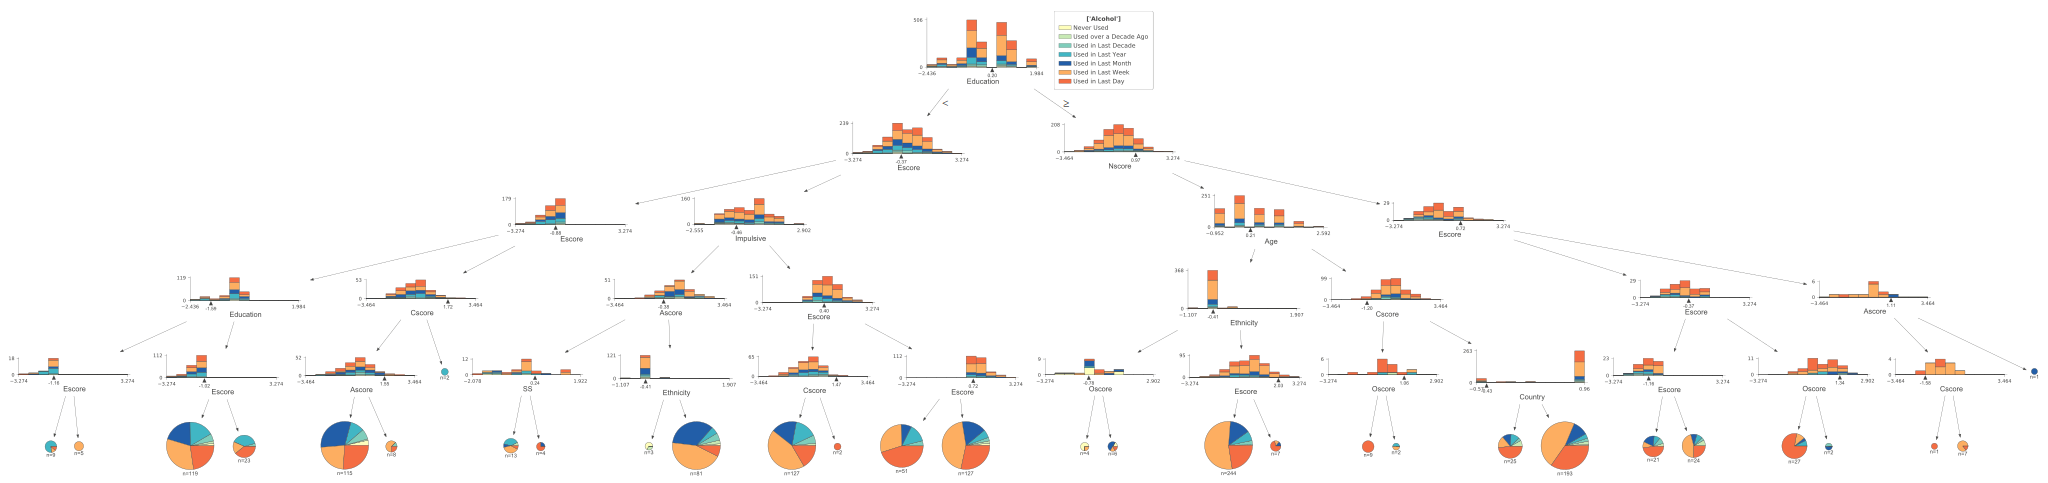

In [384]:
print_accuracy(classifiers, 'Alcohol')

## Target: _Cannabis_

Predicting accuracy for "Cannabis":

plot_xgb_trees


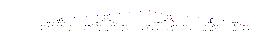

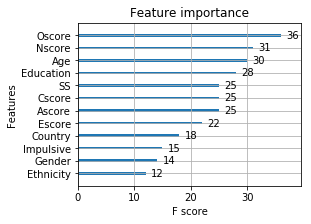

XGBClassifier
	Accuracy: 40.44943820224719
AdaBoostClassifier
	Accuracy: 34.02889245585875
RandomForestClassifier
	Accuracy: 33.386837881219904
DecisionTreeClassifier
	Accuracy: 40.44943820224719


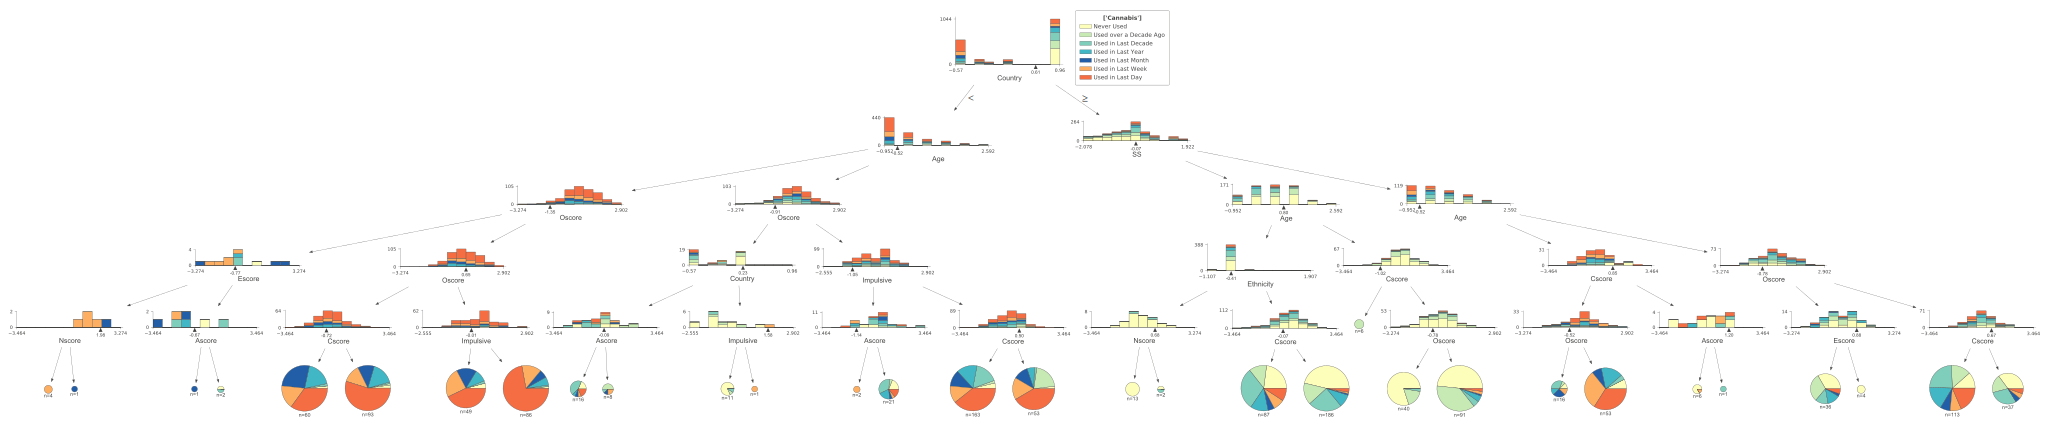

In [385]:
print_accuracy(classifiers, 'Cannabis')

## Target: _Meth_

Predicting accuracy for "Meth":

plot_xgb_trees


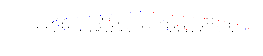

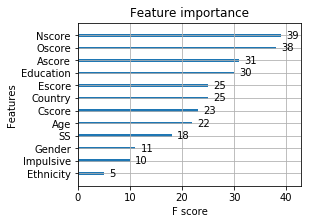

XGBClassifier
	Accuracy: 77.36757624398074
AdaBoostClassifier
	Accuracy: 33.547351524879616
RandomForestClassifier
	Accuracy: 75.76243980738363
DecisionTreeClassifier
	Accuracy: 75.12038523274478


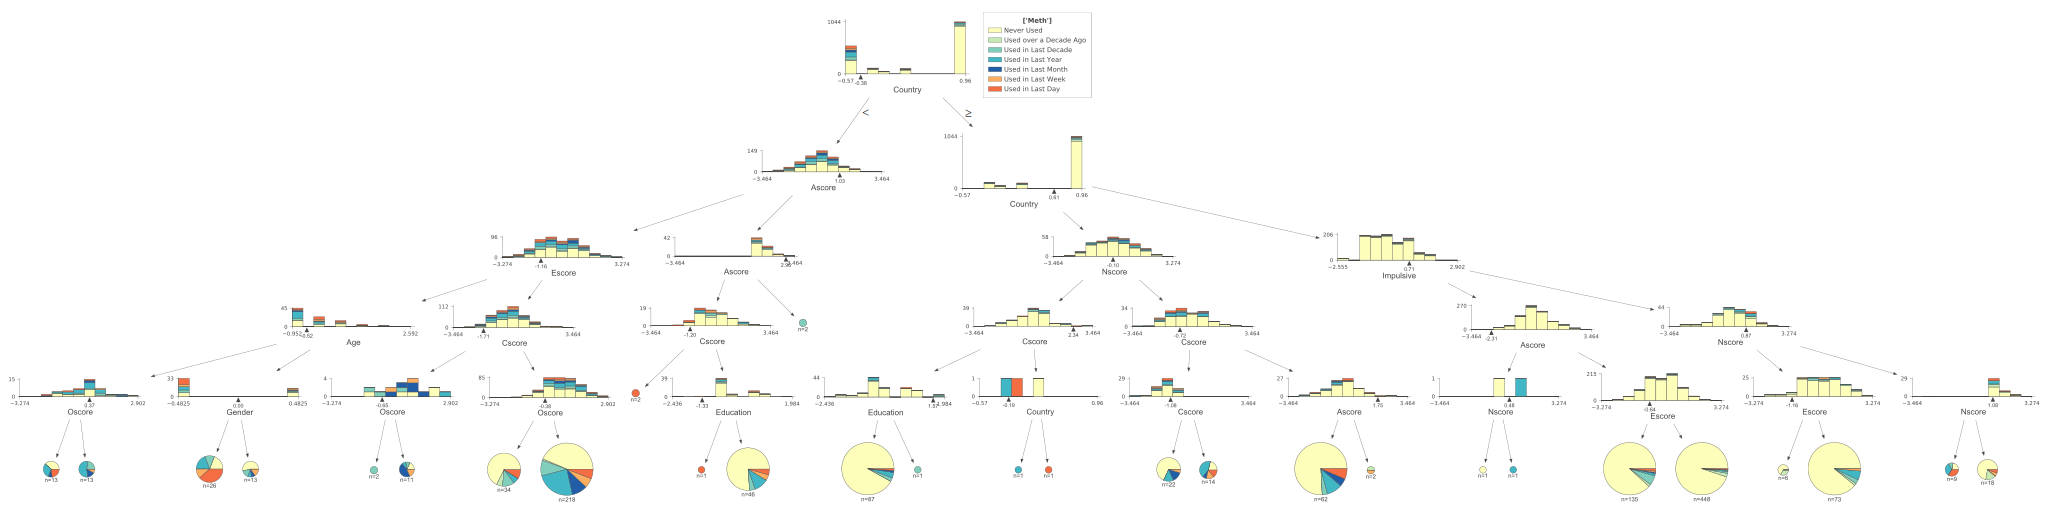

In [386]:
print_accuracy(classifiers, 'Meth')

## Target: _Crack_

In [ ]:
print_accuracy(classifiers, 'Crack')

## All Targets

Predicting accuracy for "Alcohol":

plot_xgb_trees


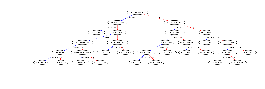

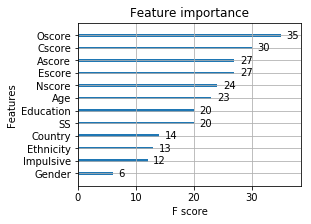

XGBClassifier
	Accuracy: 37.56019261637239
AdaBoostClassifier
	Accuracy: 26.64526484751204
RandomForestClassifier
	Accuracy: 36.91813804173354
DecisionTreeClassifier
	Accuracy: 36.43659711075441


Predicting accuracy for "Amphet":

plot_xgb_trees


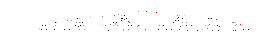

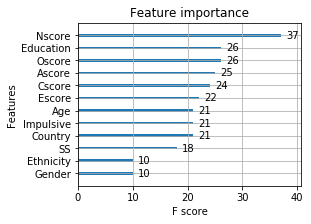

XGBClassifier
	Accuracy: 49.59871589085072
AdaBoostClassifier
	Accuracy: 35.63402889245586
RandomForestClassifier
	Accuracy: 47.19101123595505
DecisionTreeClassifier
	Accuracy: 48.31460674157304


Predicting accuracy for "Amyl":

plot_xgb_trees


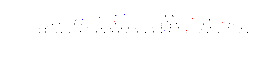

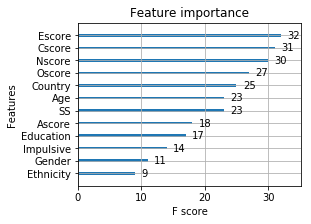

XGBClassifier
	Accuracy: 67.73675762439807
AdaBoostClassifier
	Accuracy: 39.96789727126806
RandomForestClassifier
	Accuracy: 67.09470304975923
DecisionTreeClassifier
	Accuracy: 66.93418940609952


Predicting accuracy for "Benzos":

plot_xgb_trees


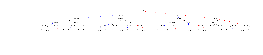

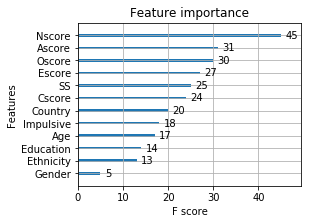

XGBClassifier
	Accuracy: 52.64847512038523
AdaBoostClassifier
	Accuracy: 37.56019261637239
RandomForestClassifier
	Accuracy: 49.59871589085072
DecisionTreeClassifier
	Accuracy: 52.32744783306581


Predicting accuracy for "Caff":

plot_xgb_trees


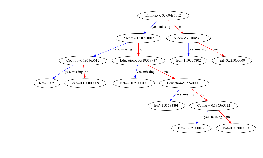

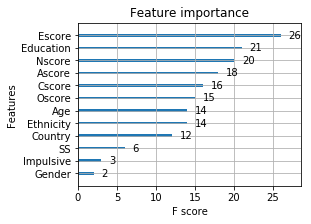

XGBClassifier
	Accuracy: 74.31781701444623
AdaBoostClassifier
	Accuracy: 58.10593900481541
RandomForestClassifier
	Accuracy: 69.98394863563404
DecisionTreeClassifier
	Accuracy: 72.07062600321026


Predicting accuracy for "Cannabis":

plot_xgb_trees


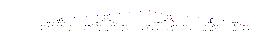

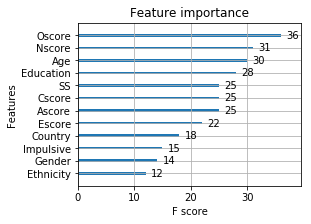

XGBClassifier
	Accuracy: 40.44943820224719
AdaBoostClassifier
	Accuracy: 34.02889245585875
RandomForestClassifier
	Accuracy: 33.386837881219904
DecisionTreeClassifier
	Accuracy: 40.44943820224719


Predicting accuracy for "Choc":

plot_xgb_trees


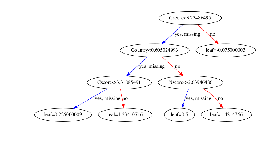

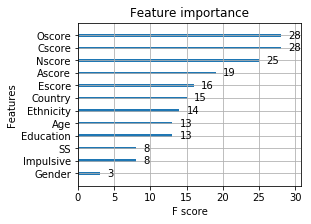

XGBClassifier
	Accuracy: 41.091492776886035
AdaBoostClassifier
	Accuracy: 41.73354735152488
RandomForestClassifier
	Accuracy: 37.7207062600321
DecisionTreeClassifier
	Accuracy: 42.857142857142854


Predicting accuracy for "Coke":

plot_xgb_trees


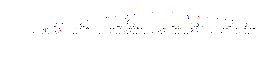

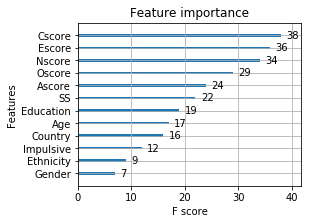

XGBClassifier
	Accuracy: 54.574638844301774
AdaBoostClassifier
	Accuracy: 38.68378812199037
RandomForestClassifier
	Accuracy: 52.1669341894061
DecisionTreeClassifier
	Accuracy: 53.6115569823435


Predicting accuracy for "Crack":

plot_xgb_trees


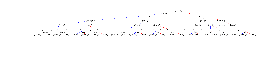

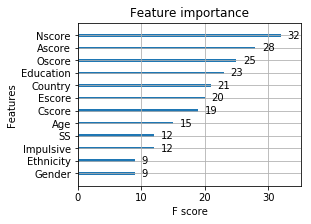

XGBClassifier
	Accuracy: 86.35634028892456
AdaBoostClassifier
	Accuracy: 86.51685393258427
RandomForestClassifier
	Accuracy: 86.03531300160515
DecisionTreeClassifier
	Accuracy: 84.43017656500803


Predicting accuracy for "Ecstasy":

plot_xgb_trees


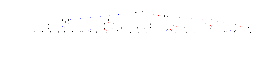

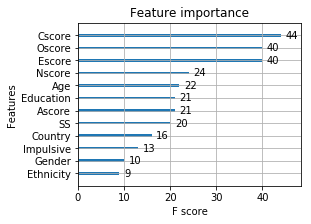

XGBClassifier
	Accuracy: 53.77207062600321
AdaBoostClassifier
	Accuracy: 41.41252006420545
RandomForestClassifier
	Accuracy: 54.73515248796148
DecisionTreeClassifier
	Accuracy: 50.08025682182986


Predicting accuracy for "Heroin":

plot_xgb_trees


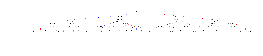

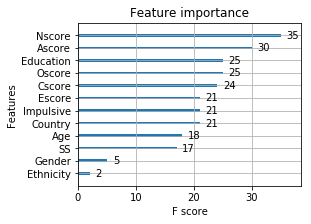

XGBClassifier
	Accuracy: 85.39325842696628
AdaBoostClassifier
	Accuracy: 28.41091492776886
RandomForestClassifier
	Accuracy: 84.91171749598716
DecisionTreeClassifier
	Accuracy: 84.59069020866774


Predicting accuracy for "Ketamine":

plot_xgb_trees


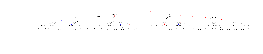

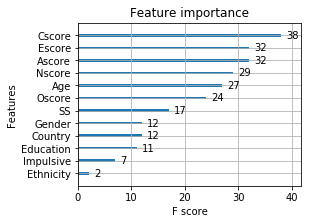

XGBClassifier
	Accuracy: 79.61476725521669
AdaBoostClassifier
	Accuracy: 73.03370786516854
RandomForestClassifier
	Accuracy: 78.65168539325843
DecisionTreeClassifier
	Accuracy: 77.68860353130016


Predicting accuracy for "Legalh":

plot_xgb_trees


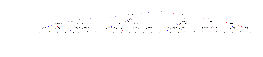

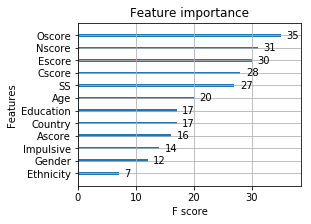

XGBClassifier
	Accuracy: 63.08186195826645
AdaBoostClassifier
	Accuracy: 46.22792937399679
RandomForestClassifier
	Accuracy: 63.56340288924559
DecisionTreeClassifier
	Accuracy: 62.92134831460674


Predicting accuracy for "LSD":

plot_xgb_trees


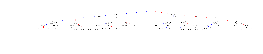

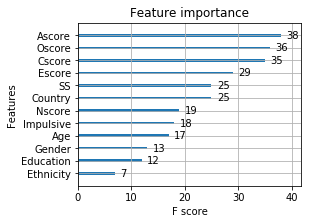

XGBClassifier
	Accuracy: 58.74799357945425
AdaBoostClassifier
	Accuracy: 24.719101123595504
RandomForestClassifier
	Accuracy: 56.01926163723917
DecisionTreeClassifier
	Accuracy: 57.30337078651685


Predicting accuracy for "Meth":

plot_xgb_trees


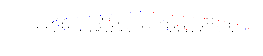

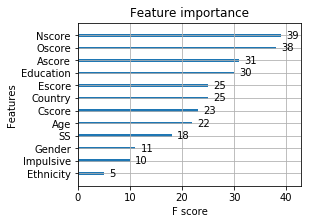

XGBClassifier
	Accuracy: 77.36757624398074
AdaBoostClassifier
	Accuracy: 33.547351524879616
RandomForestClassifier
	Accuracy: 75.76243980738363
DecisionTreeClassifier
	Accuracy: 75.12038523274478


Predicting accuracy for "Shrooms":

plot_xgb_trees


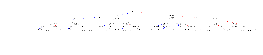

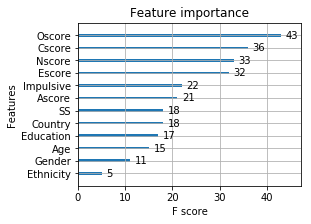

XGBClassifier
	Accuracy: 51.84590690208668
AdaBoostClassifier
	Accuracy: 42.0545746388443
RandomForestClassifier
	Accuracy: 51.36436597110754
DecisionTreeClassifier
	Accuracy: 53.45104333868379


Predicting accuracy for "Nicotine":

plot_xgb_trees


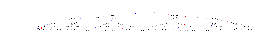

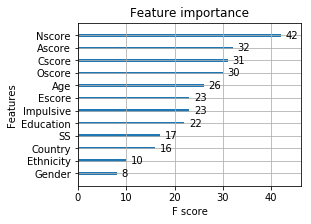

XGBClassifier
	Accuracy: 36.75762439807384
AdaBoostClassifier
	Accuracy: 24.879614767255216
RandomForestClassifier
	Accuracy: 32.102728731942214
DecisionTreeClassifier
	Accuracy: 34.67094703049759


Predicting accuracy for "Semer":

plot_xgb_trees


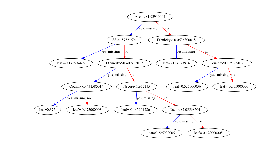

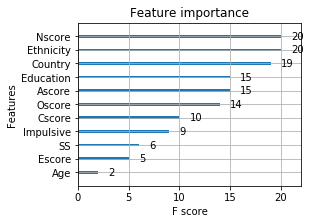

XGBClassifier
	Accuracy: 99.51845906902086
AdaBoostClassifier
	Accuracy: 98.7158908507223
RandomForestClassifier
	Accuracy: 99.51845906902086


IndexError: list index out of range

In [388]:
for target in targets:
    print_accuracy(classifiers, target, False)
    print('\n')

## Future Work

- Boosting of models for better performance
- Better graphical representations
- Benchmarking the 